In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#imporitng the data set using read_spss command
df =  pd.read_spss('secom_mod.SAV')

In [3]:
#Splitting the dataset to Test and Train
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

X = df.drop(['class'], axis= 1)
y = df['class']


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.3,stratify=y, random_state=42)
X_train = X_train.copy()

pd.set_option('display.max_columns', None)

In [4]:
#making the class as categorical value

y_train = y_train.astype('category')
assert y_train.dtype == 'category'

In [5]:
#dropping the timestamp column as it is not used for modelling

X_train = X_train.drop(['ID', 'timestamp'],axis = 1)

In [6]:
X_train1 = X_train.drop(X_train.columns[X_train.apply(lambda col: col.isnull().sum()/len(df) > 0.55)], axis=1)

In [7]:
X_train2 = X_train1.drop(X_train1.columns[X_train1.apply(lambda col: col.nunique()) == 1],axis=1)

In [8]:
def outlier_detection_and_replacement(DataSet):
    DataSet.fillna(0)
    Q1 = DataSet.quantile(0.25)
    Q3 = DataSet.quantile(0.75)
    IQR = Q3 - Q1

    DataSet[(DataSet < (Q1 - 1.5 * IQR)) | (DataSet > (Q3 + 1.5 * IQR))] = np.nan
    return DataSet

In [9]:
X_train3 = outlier_detection_and_replacement(X_train2)

In [10]:
#MICE imputation

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
MICE_imputer = IterativeImputer() 
X_train3_filled = X_train3.copy(deep = True)
X_train3_filled.iloc[:, :] = MICE_imputer.fit_transform(X_train3_filled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [11]:
X_train3_filled.shape

(1096, 466)

In [24]:
X1 = X_train3_filled 
Y1 = y_train.dropna()

In [22]:
#Feature selection based on RFE (Recursive Feature Elimination)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [23]:
lin_reg = LinearRegression()

In [26]:
rfe = RFE(lin_reg, 46) # selecting best 80 features for the model 
rfe.fit(X1, Y1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=46 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


RFE(estimator=LinearRegression(), n_features_to_select=46)

In [27]:
print(f"Number of selected features: {rfe.n_features_}\n\
Mask: {rfe.support_}\n\
Selected Features:", [feature for feature, rank in zip(X1.columns.values, rfe.ranking_) if rank==1],"\n\
Estimator : {rfe.estimator_}")

Number of selected features: 46
Mask: [False False False False False False False False False False False  True
 False False  True False  True False False False False False False False
 False False False False False False False False  True False  True False
 False False False False  True False  True False False  True  True False
  True  True False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True  True False  True False False False  True  True False False
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False  True
 False False False False False False False False False False False False
 False False 

In [28]:
X1_RFE = X1[['feature013', 'feature017', 'feature019', 'feature035', 'feature037', 'feature044', 'feature046', 'feature049', 'feature051', 'feature054', 'feature055', 'feature058', 'feature093', 'feature094', 'feature096', 'feature101', 'feature102', 'feature105', 'feature106', 'feature107', 'feature148', 'feature154', 'feature173', 'feature175', 'feature197', 'feature202', 'feature239', 'feature240', 'feature245', 'feature252', 'feature279', 'feature283', 'feature289', 'feature308', 'feature310', 'feature333', 'feature338', 'feature377', 'feature378', 'feature383', 'feature390', 'feature545', 'feature579', 'feature582', 'feature587', 'feature590']]

In [29]:
X1_RFE.shape

(1096, 46)

In [30]:
#importing SMOTE

from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X1_RFE, Y1)

print(f'''Shape of X before SMOTE: {X1_RFE.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1096, 46)
Shape of X after SMOTE: (2060, 46)

Balance of positive and negative classes (%):


0.0    50.0
1.0    50.0
Name: class, dtype: float64

In [85]:
X_sm.to_csv('X_train.csv',index=False)
y_sm.to_csv('y_train.csv',index=False)

In [ ]:
#TEST DATA 

In [31]:
#dropping the timestamp column as it is not used for modelling

X_test = X_test.drop(['ID', 'timestamp'],axis = 1)

In [32]:
#making the class as categorical value

y_test = y_test.astype('category')
assert y_test.dtype == 'category'

In [33]:
X_test1 = X_test.drop(X_test.columns[X_test.apply(lambda col: col.isnull().sum()/len(df) > 0.55)], axis=1)
X_test1

,feature001,feature002,feature003,feature004,feature005,feature006,feature007,feature008,feature009,feature010,feature011,feature012,feature013,feature014,feature015,feature016,feature017,feature018,feature019,feature020,feature021,feature022,feature023,feature024,feature025,feature026,feature027,feature028,feature029,feature030,feature031,feature032,feature033,feature034,feature035,feature036,feature037,feature038,feature039,feature040,feature041,feature042,feature043,feature044,feature045,feature046,feature047,feature048,feature049,feature050,feature051,feature052,feature053,feature054,feature055,feature056,feature057,feature058,feature059,feature060,feature061,feature062,feature063,feature064,feature065,feature066,feature067,feature068,feature069,feature070,feature071,feature072,feature073,feature074,feature075,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature084,feature085,feature086,feature087,feature088,feature089,feature090,feature091,feature092,feature093,feature094,feature095,feature096,feature097,feature098,feature099,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,featur

In [34]:
X_test2 = X_test1.drop(X_test1.columns[X_test1.apply(lambda col: col.nunique()) == 1],axis=1)
X_test2

,feature001,feature002,feature003,feature004,feature005,feature007,feature008,feature009,feature010,feature011,feature012,feature013,feature015,feature016,feature017,feature018,feature019,feature020,feature021,feature022,feature023,feature024,feature025,feature026,feature027,feature028,feature029,feature030,feature031,feature032,feature033,feature034,feature035,feature036,feature037,feature038,feature039,feature040,feature041,feature042,feature044,feature045,feature046,feature047,feature048,feature049,feature051,feature052,feature054,feature055,feature056,feature057,feature058,feature059,feature060,feature061,feature062,feature063,feature064,feature065,feature066,feature067,feature068,feature069,feature071,feature072,feature073,feature074,feature076,feature077,feature078,feature079,feature080,feature081,feature082,feature083,feature084,feature085,feature086,feature087,feature088,feature089,feature090,feature091,feature092,feature093,feature094,feature095,feature096,feature097,feature099,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature181,feature182,feature183,feature184,feature185,feature186,feature188,feature189,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature208,feature209,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature228,feature229,feature239,feature240,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature317,feature318,feature319,feature320,feature321,feature322,feature324,feature325,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature344,feature345,feature346,feature347,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature366,feature367,feature368,feature369,feature377,feature378,feature383,feature384,feature385,feature386,feature387,feature388,feature389,feature390,feature391,feature392,feature393,feature394,feature406,feature407,feature408,feature409,feature410,feature411,feature412,feature413,feature414,feature416,feature417,feature418,feature419,feature420,feature421,feature422,feature424,feature425,feature426,feature427,feature428,feature429,feature430,feature431,feature432,feature433,feature434,feature435,feature436,feature437,feature438,feature439,feature440,feature441,feature442,feature443,feature444,feature445,feature446,feature447,feature448,featur

In [35]:
#:: OUTLIERS HANDLING ::
X_test3 = outlier_detection_and_replacement(X_test2)

In [36]:
#MICE imputation

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
MICE_imputer = IterativeImputer() 
X_test3_filled = X_test3.copy(deep = True)
X_test3_filled.iloc[:, :] = MICE_imputer.fit_transform(X_test3_filled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [37]:
X_test3_filled.shape

(471, 468)

In [38]:
#dropping the ID column and assigning the test values

X2 = X_test3_filled
Y2 = y_test.dropna()

In [39]:
X2_RFE = X2[['feature013', 'feature017', 'feature019', 'feature035', 'feature037', 'feature044', 'feature046', 'feature049', 'feature051', 'feature054', 'feature055', 'feature058', 'feature093', 'feature094', 'feature096', 'feature101', 'feature102', 'feature105', 'feature106', 'feature107', 'feature148', 'feature154', 'feature173', 'feature175', 'feature197', 'feature202', 'feature239', 'feature240', 'feature245', 'feature252', 'feature279', 'feature283', 'feature289', 'feature308', 'feature310', 'feature333', 'feature338', 'feature377', 'feature378', 'feature383', 'feature390', 'feature545', 'feature579', 'feature582', 'feature587', 'feature590']]

In [86]:
X2_RFE.to_csv('X_test.csv',index=False)
Y2.to_csv('y_test.csv',index=False)

In [ ]:
X2_RFE

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


pipe_steps = [('scaler', StandardScaler()), ('decisionTree', DecisionTreeClassifier())]
check_params  = { 'decisionTree__criterion': ['gini', 'entropy'],
                  'decisionTree__max_depth': np.arange(3, 15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)

from tqdm import tqdm_notebook 

for cv in tqdm_notebook(range(3,10)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_sm, y_sm)
    print("score for %d fold CV := %3.2f" %(cv , create_grid.score(X_sm, y_sm)))
    print(create_grid.best_params_)


Pipeline(steps=[('scaler', StandardScaler()),
                ('decisionTree', DecisionTreeClassifier())])


<ipython-input-42-9fb57b6762fa>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cv in tqdm_notebook(range(3,10)):


  0%|          | 0/7 [00:00<?, ?it/s]

score for 3 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 14}
score for 4 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 13}
score for 5 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 14}
score for 6 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 14}
score for 7 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 14}
score for 8 fold CV := 0.99
{'decisionTree__criterion': 'entropy', 'decisionTree__max_depth': 14}
score for 9 fold CV := 0.99
{'decisionTree__criterion': 'gini', 'decisionTree__max_depth': 12}


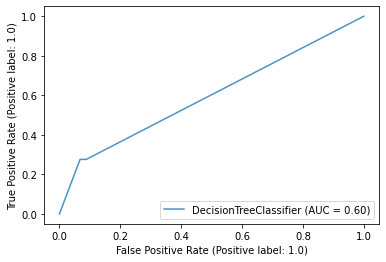

Accuracy = 0.89
Recall = 0.28

Accuracy: 0.89171974522293


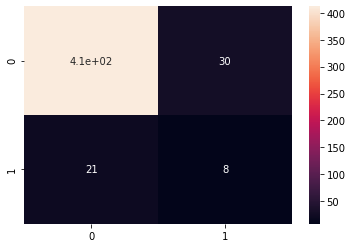

array([[412,  30],
       [ 21,   8]], dtype=int64)

In [66]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_roc_curve
import sklearn.metrics as metrics

model = DecisionTreeClassifier(criterion='entropy', max_depth=14)
model.fit(X1_RFE, Y1)
ax = plt.gca()
rfc_disp = plot_roc_curve(model, X2_RFE,Y2, ax=ax, alpha=0.8)
preds = model.predict(X2_RFE)
plt.show()

print(f'Accuracy = {accuracy_score(Y2, preds):.2f}\nRecall = {recall_score(Y2, preds):.2f}\n')
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score( Y2, preds))

cm=metrics.confusion_matrix(Y2, preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

confusion_matrix(Y2, preds)

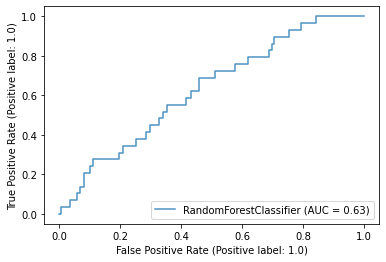

Accuracy = 0.94
Recall = 0.00



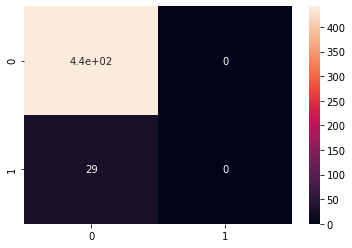

array([[442,   0],
       [ 29,   0]], dtype=int64)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

model = RandomForestClassifier(n_jobs = -1, max_depth = 5, random_state=42,)
model.fit(X1_RFE, Y1)
ax = plt.gca()
rfc_disp = plot_roc_curve(model, X2_RFE,Y2, ax=ax, alpha=0.8)
preds = model.predict(X2_RFE)
plt.show()

print(f'Accuracy = {accuracy_score(Y2, preds):.2f}\nRecall = {recall_score(Y2, preds):.2f}\n')

cm=metrics.confusion_matrix(Y2, preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

confusion_matrix(Y2, preds)

In [81]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X1_RFE, Y1)
y_pred  =  classifier.predict(X2_RFE)
from sklearn.metrics import confusion_matrix,accuracy_score
cm1 = confusion_matrix(Y2, y_pred)
ac1 = accuracy_score(Y2,y_pred)

print(f'Accuracy = {accuracy_score(Y2, preds):.2f}\nRecall = {recall_score(Y2, preds):.2f}\n')

Accuracy = 0.94
Recall = 0.00



In [75]:
print(cm)

[[423  19]
 [ 27   2]]


<AxesSubplot:>

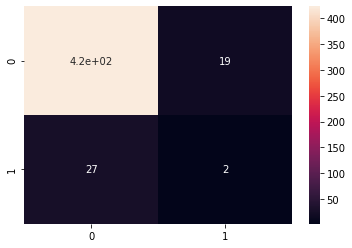

In [78]:
sns.heatmap(cm1, annot=True, annot_kws={"size": 10})

In [79]:
ac1

0.9023354564755839

In [80]:
confusion_matrix_and_metrics(model1,Y2, y_pred, X2_RFE)
plt.show()
print(f'Accuracy = {accuracy_score(Y2, y_pred):.2f}\nRecall = {recall_score(Y2, y_pred):.2f}\n')

NameError: name 'confusion_matrix_and_metrics' is not defined